<a href="https://colab.research.google.com/github/h-j-hyun/NCoin-DP/blob/main/Multi_real_adbemsft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
! pip install yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

# MLE functions
def MLE_Multi(sim_data, delta_x):
  L0 = sim_data.size()[0]
  n = sim_data.size()[2]-1
  diffSt = sim_data[:,0,1:(n+1)]  - sim_data[:,0,0:n]
  Xt = sim_data[:,1,1:(n+1)]
  Xt1 = sim_data[:,1,0:n]
  mhat = torch.sum(diffSt,1)/n
  Shat_sq = (torch.sum(torch.square(diffSt),1) - (mhat ** 2) * n) / n 
  phat = 1/ (n* torch.sum(torch.square(Xt1),1) - torch.sum(Xt1, 1) ** 2 ) * (n* torch.sum(Xt * Xt1,1) - (Xt[:,n-1] - Xt1[:,0] ) * torch.sum(Xt1, 1) -  torch.square(torch.sum(Xt1, 1)) )
  qhat = ((Xt[:,n-1] - Xt1[:,0] ) + torch.sum(Xt1,1) - phat * torch.sum(Xt1,1) )/n
  Vhat_sq = 1/n * (torch.sum(Xt**2,1) + (phat ** 2) * torch.sum(Xt1**2,1) + n * (qhat **2) - 2 * phat * torch.sum(Xt * Xt1,1) - 2* qhat *torch.sum(Xt,1) + 2* phat * qhat * torch.sum(Xt1, 1) )
  Chat = 1/(n * torch.sqrt(Vhat_sq) * torch.sqrt(Shat_sq)) * (torch.sum(Xt * diffSt,1) - phat * torch.sum(Xt1 * diffSt,1) - mhat * (Xt[:,n-1] - Xt1[:,0] ) - mhat * (1-phat) * torch.sum(Xt1,1) )

  sigmahat = torch.sqrt(Shat_sq/ delta_x)
  muhat = mhat/ delta_x + (1/2) * (sigmahat ** 2)
  kappahat = -torch.log(phat)/delta_x
  thetahat = qhat / (torch.ones(L0)- phat)
  etahat = torch.sqrt(2 * kappahat * Vhat_sq / (torch.ones(L0)-phat**2))
  rhohat = kappahat * Chat * torch.sqrt(Vhat_sq) * torch.sqrt(Shat_sq) / (etahat * sigmahat * (torch.ones(L0)-phat))
  results = torch.stack((muhat, sigmahat, kappahat, thetahat, etahat, rhohat), 1)
  return(results)


def hast(time, X, mu, sigma, kappa, alpha, eta, rho, timeT, gamma_hast):
  tmp_hast = np.sqrt(1-gamma_hast)
  tmp2_hast = np.exp(2*kappa* (timeT- time) / tmp_hast)
  alphat = kappa * (1 - tmp_hast)/ (2* eta**2) * (1 + 2 * tmp_hast / (1 - tmp_hast - (1+ tmp_hast) *tmp2_hast ) )
  betat = 1/ (2*eta**2 * ( (1-tmp_hast) - (1+tmp_hast) *tmp2_hast) ) 
  betat = betat * (gamma_hast*tmp_hast*(eta**2+2*rho*sigma*eta) * (1-tmp2_hast)**2 - gamma_hast* (eta**2 + 2*rho*sigma*eta + 2*kappa*alpha)* (1-tmp2_hast)  )
  result = 1/ (1-gamma_hast) * (betat+ 2* X * alphat - kappa* (X-alpha)/eta**2 + rho* sigma/eta + 1/2)
  return(result)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 99.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
data1 =  yf.download("ADBE MSFT", start="2013-01-01", end="2017-12-31")
data2 =  yf.download("ADBE MSFT ", start="2017-12-31", end="2019-01-01")
# Using the Adj Close prices for our dataset
data_train_dataframe = data1["Adj Close"][["ADBE", "MSFT"]]
data_test_dataframe = data2["Adj Close"][["ADBE", "MSFT"]]
print(data1)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
             Adj Close                  Close                   High  \
                  ADBE       MSFT        ADBE       MSFT        ADBE   
Date                                                                   
2013-01-02   38.340000  22.717781   38.340000  27.620001   38.730000   
2013-01-03   37.750000  22.413448   37.750000  27.250000   38.299999   
2013-01-04   38.130001  21.993971   38.130001  26.740000   38.189999   
2013-01-07   37.939999  21.952847   37.939999  26.690001   38.209999   
2013-01-08   38.139999  21.837696   38.139999  26.549999   38.200001   
...                ...        ...         ...        ...         ...   
2017-12-22  175.000000  80.324844  175.000000  85.510002  175.100006   
2017-12-26  174.440002  80.221519  174.440002  85.400002  175.000000   
2017-12-27  175.360001  80.512695  175.360001  85.709999  175.440002  

[ 38.34000015  37.75        38.13000107 ... 175.36000061 175.55000305
 175.24000549]
(1259, 2)
(251, 2)


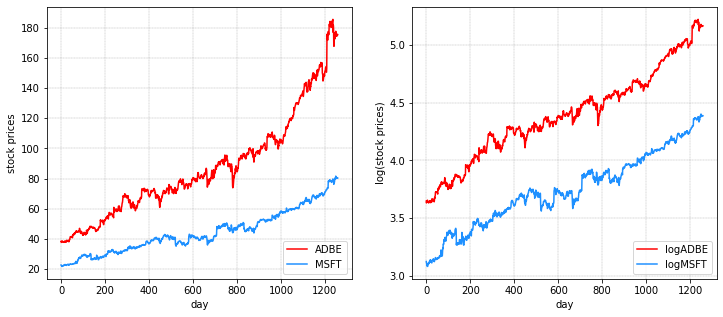

In [ ]:
data_train = data_train_dataframe.to_numpy()
data_test = data_test_dataframe.to_numpy()

print(data_train[:,0])
print(data_train.shape)
print(data_test.shape)

fig, axes = plt.subplots(1, 2, figsize=(12,5)) 
axes[0].plot(data_train[:,0], color = "red") 
axes[0].plot(data_train[:,1], color = "dodgerblue")
axes[0].set_axisbelow(True)
axes[0].grid(color='gray', linestyle='--', linewidth = 0.3)
axes[0].set_xlabel(r'day', fontsize=10 )
axes[0].set_ylabel(r'stock prices', fontsize=10 )
axes[0].legend(('ADBE','MSFT'), loc='lower right')


axes[1].plot(np.log(data_train[:,0]), color = "red")  
axes[1].plot(np.log(data_train[:,1]), color = "dodgerblue")
axes[1].set_axisbelow(True)
axes[1].grid(color='gray', linestyle='--', linewidth = 0.3)
axes[1].set_xlabel(r'day', fontsize=10 )
axes[1].set_ylabel(r'log(stock prices)', fontsize=10 )
axes[1].legend(('logADBE','logMSFT'), loc='lower right')


#fig.savefig("raw.pdf", bbox_inches='tight')
#files.download("raw.pdf")

Text(0.5, 0, 'day')

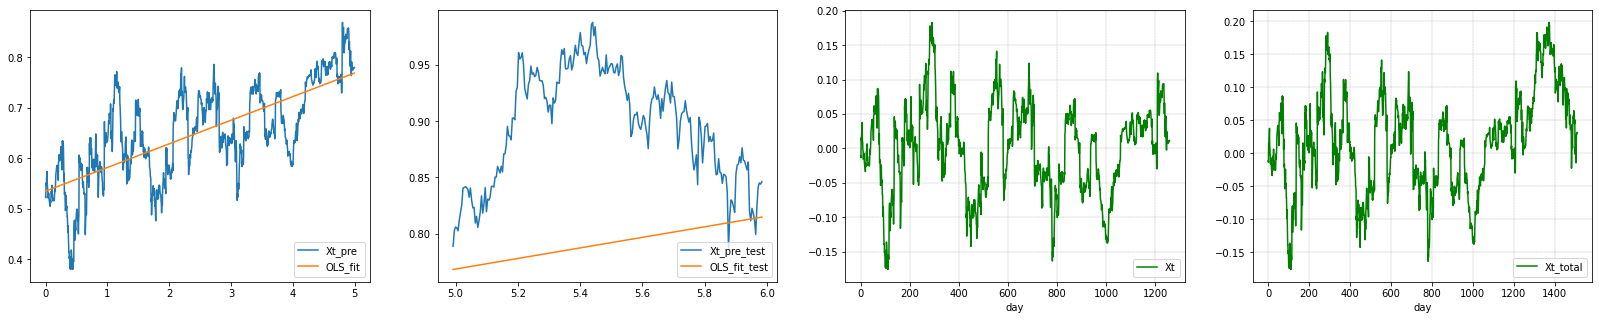

In [ ]:
import statsmodels
import statsmodels.api as sm
n0 = data_train.shape[0]-1
obtime = np.arange(0, n0 + 1)/n0 * n0 * 1/252
Xt_pre = np.log(data_train[:,0]) - np.log(data_train[:,1])

# adding the constant term
obtime_OLS = sm.add_constant(obtime)
results = sm.OLS(Xt_pre, obtime_OLS).fit()

OLS_fit = results.params[0] + obtime* results.params[1]


Xt_train = Xt_pre - OLS_fit
St_train = np.log(data_train[:,1]) # ln Bt
lnAt_train = St_train + Xt_train
At_train = np.exp(lnAt_train)
Bt_train = np.exp(St_train)

Xt_pre_test = np.log(data_test[:,0]) - np.log(data_test[:,1])
n01 = data_test.shape[0]-1
obtime_test = np.arange(n0, n0+n01 +1 )/n01 *n01 * 1/252

OLS_fit_test = results.params[0] + obtime_test* results.params[1]

Xt_test = Xt_pre_test - OLS_fit_test
St_test = np.log(data_test[:,1]) # ln Bt
lnAt_test = St_test + Xt_test
At_test = np.exp(lnAt_test)
Bt_test = np.exp(St_test)


fig, axes = plt.subplots(1, 4, figsize=(28,5)) 
axes[0].plot(obtime,Xt_pre)
axes[0].plot(obtime,OLS_fit)
axes[0].legend(('Xt_pre','OLS_fit'), loc='lower right')



axes[1].plot(obtime_test,Xt_pre_test)
axes[1].plot(obtime_test,OLS_fit_test)
axes[1].legend(('Xt_pre_test','OLS_fit_test'), loc='lower right')

axes[2].plot(Xt_pre - OLS_fit, color = "green")  
axes[2].legend(['Xt'], loc='lower right')
axes[2].set_axisbelow(True)
axes[2].grid(color='gray', linestyle='--', linewidth = 0.3)
axes[2].set_xlabel(r'day', fontsize=10 )


axes[3].plot( np.append(Xt_train, Xt_test) ,color = "green")  
axes[3].legend(['Xt_total'], loc='lower right')
axes[3].set_axisbelow(True)
axes[3].grid(color='gray', linestyle='--', linewidth = 0.3)
axes[3].set_xlabel(r'day', fontsize=10 )


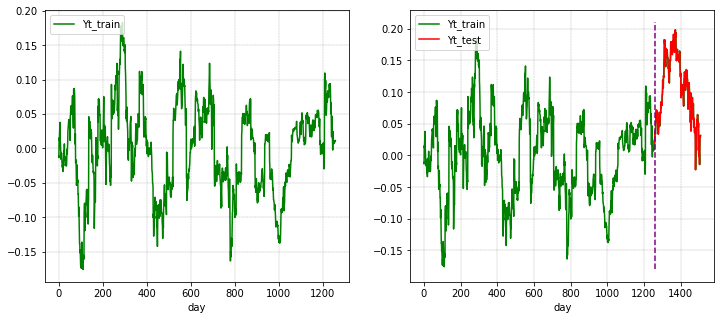

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5)) 

axes[0].plot(Xt_pre - OLS_fit, color = "green")  
axes[0].legend(['Yt_train'], loc='upper left')
axes[0].set_axisbelow(True)
axes[0].grid(color='gray', linestyle='--', linewidth = 0.3)
axes[0].set_xlabel(r'day', fontsize=10 )


axes[1].plot( np.append(Xt_train, Xt_test) ,color = "green")  
axes[1].plot( np.arange(n0, n0+n01 +1 ),Xt_test ,color = "red")  
axes[1].legend(['Yt_train', 'Yt_test'], loc='upper left')
axes[1].set_axisbelow(True)
axes[1].grid(color='gray', linestyle='--', linewidth = 0.3)
axes[1].set_xlabel(r'day', fontsize=10 )
# single line
axes[1].vlines(x = n0+1, ymin = -0.18, ymax = 0.21, linestyle = '--',
           colors = 'purple')

#fig.savefig("mean_revert.pdf", bbox_inches='tight')
#files.download("mean_revert.pdf")

In [ ]:
lndata_train = torch.reshape(torch.from_numpy(np.array([St_train,Xt_train])).type(torch.float32),(1,2,St_train.shape[0]))
MLE_est = MLE_Multi(lndata_train, 1/252)[0]
MLE_est =MLE_est.detach().cpu().numpy()
print(MLE_est)

[ 2.7801135e-01  2.2339819e-01  7.4795947e+00  6.0724549e-04
  2.4960239e-01 -4.7840086e-01]


In [ ]:
print(n0,n01)

1258 250


In [ ]:
#Initial value set to be stationary distribution
s0 = St_train[0]
x0 = Xt_train[1]

# Number of data points
# m_x is the number of slicing between the interval of X_t to approximate X_t
n= St_train.shape[0]-1
m_x = 20

# time inteval
delta_x = 1/252 


# Generating x
obtime_x = np.arange(0, n + 1)/n * n * delta_x

# For save
from google.colab import drive
drive.mount('/content/gdrive1')
model_save_name = 'Multi_real_msftadbe.pt'
path = F"/content/gdrive1/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive1; to attempt to forcibly remount, call drive.mount("/content/gdrive1", force_remount=True).


In [ ]:
def Multi_sample(s0_Multi, x0_Multi, t_Multi, m0, mu_Multi, sigma_Multi, kappa_Multi, alpha_Multi, eta_Multi, rho_Multi):
    """
    This function generates a sample path for a multivariate process following
    x0, y0: initial value
    t: time array including initial point
    # dS_t = (mu - 1/2 sigma^2) dt + sigma dZ_t
    # dX_t = kappa(theta - X_t) dt + eta dW_t
    # Cov(dZ_t, dW_t) = rho dt
"""
    
    s0 = s0_Multi
    x0 = x0_Multi

    L_Multi = x0_Multi.size()[0]

    path_Multi = torch.zeros(L_Multi, 2, t_Multi.size)
    path_Multi[:,0,0] = s0_Multi
    path_Multi[:,1,0] = x0_Multi
    
    
    for l in range(t_Multi.size-1):
        # X, Y generating
        del_x = t_Multi[l+1] - t_Multi[l]
        del_y = del_x / m0

        for j in range(m0):
            ran_num1 = torch.normal(0 * torch.ones(L_Multi), 1 * torch.ones(L_Multi))
            ran_num2 = torch.normal(0 * torch.ones(L_Multi), 1 * torch.ones(L_Multi))
            s0 =  s0 + (mu_Multi - (1/2) * sigma_Multi ** 2 ) * torch.ones(L_Multi) * del_y +  sigma_Multi * ran_num1 * ((del_y)**(1/2)) # Euler approximation
            x0 =  x0 + kappa_Multi* (alpha_Multi * torch.ones(L_Multi) - x0) * del_y +  eta_Multi * ( rho_Multi * ran_num1 + (torch.sqrt( torch.ones(L_Multi)- (torch.pow(rho_Multi,2)) ) * ran_num2 ) ) * ((del_y)**(1/2))
            
        path_Multi[:,0,l+1] = s0
        path_Multi[:,1,l+1] = x0
    return(path_Multi)
   ## return(x_Hes)
print(MLE_est)

[ 2.7801135e-01  2.2339819e-01  7.4795947e+00  6.0724549e-04
  2.4960239e-01 -4.7840086e-01]


In [ ]:
L = 200000
Lval = 40000
Ltest = 5000

mu_range = [-0.5, 0.8]
sigma_range = [0.0, 0.8]

kappa_range = [2, 9]
alpha_range = [-0.5, 0.5]
eta_range = [0.05, 0.5]

rho_range = [-1, 1] 
p = 6

In [ ]:
#Training + Test data generating
torch.manual_seed(510)
mu_ran    = torch.rand(L) * (mu_range[1] - mu_range[0]) + mu_range[0]  
sigma_ran   = torch.rand(L) * (sigma_range[1] - sigma_range[0]) + sigma_range[0]  

kappa_ran   = torch.rand(L) * (kappa_range[1] - kappa_range[0]) + kappa_range[0]  
alpha_ran   = torch.rand(L) * (alpha_range[1] - alpha_range[0]) + alpha_range[0]  
eta_ran   = torch.rand(L) * (eta_range[1] - eta_range[0]) + eta_range[0]  

rho_ran    = torch.rand(L) * (rho_range[1] -  rho_range[0]) + rho_range[0]  


# Output: L x p matrix
output = torch.stack((mu_ran, sigma_ran, kappa_ran, alpha_ran, eta_ran, rho_ran), dim = 1)

In [ ]:
# Generating the y simulated
# It can take about a minute.
torch.manual_seed(2726)

s0_tmp = s0 * torch.ones(L)
x0_tmp = x0 * torch.ones(L)

xL = Multi_sample(s0_tmp, x0_tmp, obtime_x, 10, mu_ran, sigma_ran, kappa_ran, alpha_ran, eta_ran, rho_ran)

In [ ]:
def moment_L(ten):
    """
    ten: torch with size: [L,2,n]
    """
    L0 = ten.size()[0]
    n0 = ten.size()[2]

    sum1_1 = torch.zeros(L0) # sum (s_i - s_{i-1})
    sum1_2 = torch.zeros(L0) # sum (s_{i} - s_{i-1})^2
    sum1_3 = torch.zeros(L0) # sum (s_{i} - s_{i-1})^3
    sum1_4 = torch.zeros(L0) # sum (s_{i} - s_{i-1})^4
    sum1_5 = torch.zeros(L0) # sum (s_{i} - s_{i-1})/s_{i-1}
    sum1_6 = torch.zeros(L0) # sum (s_{i} - s_{i-1})^2/s_{i-1}


    sum2_1 = torch.zeros(L0) # sum x_i x_{i-1}
    sum2_2 = torch.zeros(L0) # sum x_i
    sum2_3 = torch.zeros(L0) # sum x_{i-1}
    sum2_4 = torch.zeros(L0) # sum x_i ^2
    sum2_5 = torch.zeros(L0) # sum x_{i-1} ^2
    sum2_6 = torch.zeros(L0) # 
    sum2_7 = torch.zeros(L0) # 
    sum2_8 = torch.zeros(L0) # 
    sum2_9 = torch.zeros(L0) # 
    
    
    sum12_1 = torch.zeros(L0) #
    sum12_2 = torch.zeros(L0) # 
    sum12_3 = torch.zeros(L0) # 
    sum12_4 = torch.zeros(L0) # 
    sum12_5 = torch.zeros(L0) # 
    sum12_6 = torch.zeros(L0) #
    sum12_7 = torch.zeros(L0) #
    sum12_8 = torch.zeros(L0) #
    sum12_9 = torch.zeros(L0) #
    sum12_10 = torch.zeros(L0) #
    sum12_11 = torch.zeros(L0) #
    sum12_12 = torch.zeros(L0) #
    
    for l in range(n0-1):
      sum1_1 = sum1_1 + (ten[:,0,l+1] - ten[:,0,l] )
      sum1_2 = sum1_2 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 2)
      sum1_3 = sum1_3 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 3)
      sum1_4 = sum1_4 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 4)
      
      sum2_1 = sum2_1 + ten[:,1,l+1] * ten[:,1,l]
      sum2_2 = sum2_2 + ten[:,1,l+1]
      sum2_3 = sum2_3 + ten[:,1,l]
      sum2_4 = sum2_4 + torch.pow(ten[:,1,l+1], 2)
      sum2_5 = sum2_5 + torch.pow(ten[:,1,l],2)
      
      sum2_6 = sum2_6 + (ten[:,1,l+1] - ten[:,1,l])
      sum2_7 = sum2_7 + torch.pow(ten[:,1,l+1] - ten[:,1,l], 2)
      sum2_8 = sum2_8 + torch.pow(ten[:,1,l+1]- ten[:,1,l], 3)
      sum2_9 = sum2_9 + torch.pow(ten[:,1,l]- ten[:,1,l], 4)
      
      sum12_1 = sum12_1 + (ten[:,0,l+1] - ten[:,0,l] ) * ten[:,1,l]
      sum12_2 = sum12_2 + (ten[:,0,l+1] - ten[:,0,l] ) * ten[:,1,l+1]
      
      #sum12_3 = sum12_3 + (ten[:,0,n0-1]) * ten[:,1,l]
      #sum12_4 = sum12_4 + (ten[:,0,n0-1]) * ten[:,1,l+1]
      

      sum12_5 = sum12_5 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 2) * ten[:,1,l]
      sum12_6 = sum12_6 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 2) * ten[:,1,l+1]
      
      sum12_7 = sum12_7 + (ten[:,0,l+1] - ten[:,0,l] ) * torch.pow(ten[:,1,l],2)
      sum12_8 = sum12_8 + (ten[:,0,l+1] - ten[:,0,l] ) * torch.pow(ten[:,1,l+1],2)
      sum12_9 = sum12_9 + (ten[:,0,l+1] - ten[:,0,l] ) * ten[:,1,l+1] * ten[:,1,l]
      
      sum12_10 = sum12_10 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 2) * torch.pow(ten[:,1,l],2)
      sum12_11 = sum12_11 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 2) * torch.pow(ten[:,1,l+1],2)
      sum12_12 = sum12_12 + torch.pow((ten[:,0,l+1] - ten[:,0,l] ), 2) * ten[:,1,l] * ten[:,1,l+1]
      
    stack_x = torch.stack((sum1_1/n0, sum1_2/n0, sum1_3/n0, sum1_4/n0),1)
    stack_y = torch.stack((sum2_1/n0, sum2_2/n0, sum2_3/n0, sum2_4/n0, sum2_5/n0, sum2_6/n0, sum2_7/n0, sum2_8/n0, sum2_9/n0),1)
    stack_xy = torch.stack((sum12_1/n0, sum12_2/n0, sum12_5/n0, sum12_6/n0, sum12_7/n0, sum12_8/n0, sum12_9/n0, sum12_10/n0, sum12_11/n0, sum12_12/n0), 1)
    
    return(torch.cat([stack_x, stack_y, stack_xy], 1))
tmp = moment_L(xL)

In [ ]:
for i in range(tmp.size()[1]):
  print(i, torch.max(tmp[:,i]) )

0 tensor(0.0061)
1 tensor(0.0029)
2 tensor(5.5516e-05)
3 tensor(2.5648e-05)
4 tensor(0.6485)
5 tensor(0.6793)
6 tensor(0.6787)
7 tensor(0.6489)
8 tensor(0.6488)
9 tensor(0.0009)
10 tensor(0.0011)
11 tensor(8.3449e-06)
12 tensor(0.)
13 tensor(0.0034)
14 tensor(0.0041)
15 tensor(0.0014)
16 tensor(0.0014)
17 tensor(0.0020)
18 tensor(0.0028)
19 tensor(0.0024)
20 tensor(0.0011)
21 tensor(0.0011)
22 tensor(0.0011)


In [ ]:
import torch
X = torch.clone(tmp)
#tmp = [X, output]
#torch.save(tmp, "/content/gdrive1/My Drive/real_synthetic.pt" )

torch.Size([200000, 23])
torch.Size([200000, 6])


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive1')
#import torch
#[X, output] = torch.load("/content/gdrive1/My Drive/real_synthetic.pt")

Drive already mounted at /content/gdrive1; to attempt to forcibly remount, call drive.mount("/content/gdrive1", force_remount=True).


In [ ]:
L = 200000
Lval = 40000
Ltest = 5000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

torch.Size([155000, 23]) torch.Size([40000, 23]) torch.Size([5000, 23])


In [ ]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size
BATCH_SIZE = 64
torch.manual_seed(2726)

# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

# Create the model, loss function, and optimizer
D_in, H, H2, H3, D_out = 23, 64, 128, 64, 6

torch.manual_seed(2726)

# Dropout rate
p1, p2, p3 = .2, .2, .2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.bn1 = nn.BatchNorm1d(num_features=H)
        self.dn1 = nn.Dropout(p1)
        
        self.fc2 = nn.Linear(H, H2)
        self.bn2 = nn.BatchNorm1d(num_features=H2)
        self.dn1 = nn.Dropout(p2)
        
        self.fc3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(num_features=H3)
        self.dn1 = nn.Dropout(p3)
        
        self.fc4 = nn.Linear(H3, D_out)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

net = Net()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive1')
model_save_name = 'Multi_real_msftadbe.pt'
path = F"/content/gdrive1/My Drive/{model_save_name}" 

Drive already mounted at /content/gdrive1; to attempt to forcibly remount, call drive.mount("/content/gdrive1", force_remount=True).


In [ ]:
# Get the dataset size for printing (it is equal to N_SAMPLES)
dataset_size = len(dataloader.dataset)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

19014

train_loss: 35.871288  [   64/155000]
train_loss: 29.999420  [ 6464/155000]
train_loss: 26.329281  [12864/155000]
train_loss: 20.711470  [19264/155000]
train_loss: 19.983959  [25664/155000]
train_loss: 21.821535  [32064/155000]
train_loss: 14.795221  [38464/155000]
train_loss: 15.408389  [44864/155000]
train_loss: 13.612935  [51264/155000]
train_loss: 9.663519  [57664/155000]
train_loss: 9.442425  [64064/155000]
train_loss: 8.601009  [70464/155000]
train_loss: 7.111414  [76864/155000]
train_loss: 5.732829  [83264/155000]
train_loss: 6.552254  [89664/155000]
train_loss: 5.377115  [96064/155000]
train_loss: 4.956730  [102464/155000]
train_loss: 3.819426  [108864/155000]
train_loss: 4.054906  [115264/155000]
train_loss: 4.442105  [121664/155000]
train_loss: 3.277393  [128064/155000]
train_loss: 4.459914  [134464/155000]
train_loss: 4.283557  [140864/155000]
train_loss: 3.045672  [147264/155000]
train_loss: 3.831871  [153664/155000]
Epoch 1
-------------------------------
train_loss 3.9998

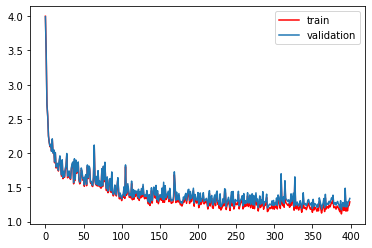

In [ ]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
# 4 -> 200  5 -> 200 6 -> 200
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

N_EPOCHS = 400
train_error_plt = []
validation_error_plt = []

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):

        y_batch_pred = net(x_batch)
        loss = loss_fn(y_batch_pred, y_batch)
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 100 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")
    
    with torch.no_grad():
          #Test loss
           net.eval()
           theta_pred_train = net(X_train)
           train_loss = loss_fn(y_train, theta_pred_train) / (L-Ltest-Lval)
           train_error_plt = np.append(train_error_plt, train_loss)
           
           theta_pred_val = net(X_val)
           validation_loss = loss_fn(y_val, theta_pred_val) / Lval
           validation_error_plt = np.append(validation_error_plt, validation_loss)

    # Choose Best Model
    if validation_error_plt[epoch] == np.min(validation_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)


    if epoch % 100 ==49:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} validation_loss {validation_loss:>7f}")

    
net.load_state_dict(torch.load(path))
#net(X_o)
print(best)
#print(net(X_o))
plt.plot(np.arange(N_EPOCHS), train_error_plt, color = "r")
plt.plot(np.arange(N_EPOCHS), validation_error_plt)
plt.legend(["train", "validation"], loc ="upper right")

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')
net.load_state_dict(torch.load(path))
net.eval()
print(loss_fn(y_val, net(X_val)) / Lval)

tensor(1.1725, grad_fn=<DivBackward0>)


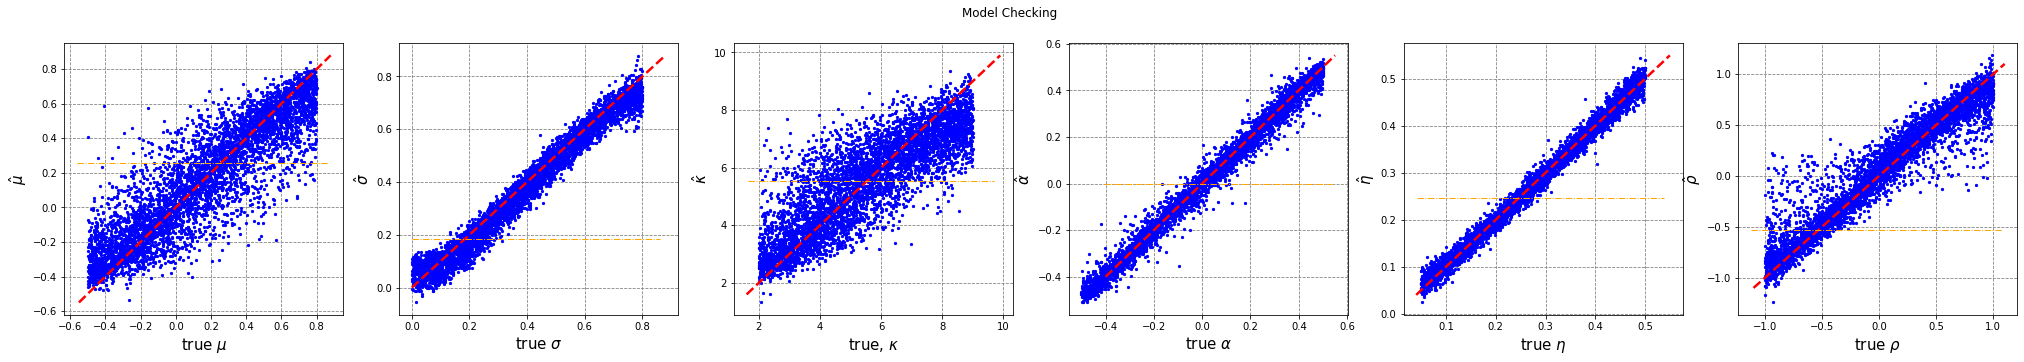

In [ ]:
DESP_est = net(moment_L(lndata_train))[0]
DESP_est = DESP_est.detach().cpu().numpy()

with torch.no_grad():
  net.eval()
  tmp1 = net(X_test)[:,0]
  tmp2 = net(X_test)[:,1]
  tmp3 = net(X_test)[:,2]
  tmp4 = net(X_test)[:,3]
  tmp5 = net(X_test)[:,4]
  tmp6 = net(X_test)[:,5]
  
  tmp1 = tmp1.detach().cpu().numpy().tolist()
  tmp2 = tmp2.detach().cpu().numpy().tolist()
  tmp3 = tmp3.detach().cpu().numpy().tolist()
  tmp4 = tmp4.detach().cpu().numpy().tolist()
  tmp5 = tmp5.detach().cpu().numpy().tolist()
  tmp6 = tmp6.detach().cpu().numpy().tolist()



# Plot for model checking
lim1 = [mu_range[0] * 1.1, mu_range[1] * 1.1]
lim2 = [sigma_range[0] * 0.8, sigma_range[1] * 1.1]
lim3 = [kappa_range[0] * 0.8, kappa_range[1] * 1.1]
lim4 = [alpha_range[0] * 0.8, alpha_range[1] * 1.1]
lim5 = [eta_range[0] * 0.8, eta_range[1] * 1.1]
lim6 = [rho_range[0] * 1.1, rho_range[1] * 1.1]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(35,5))
fig.suptitle('Model Checking')

ax1.scatter(y_test[:,0], tmp1, marker='o', color='b', s = 5)
ax1.set_xlabel(r'true $\mu$', fontsize=15)
ax1.set_ylabel(r'$\hat{\mu}$', fontsize=15)
ax1.plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
ax1.hlines(y = DESP_est[0], xmin = lim1[0]*1.02, xmax = lim1[1]*0.98, color = "orange", linestyle ="dashdot", linewidth = 1)

ax2.scatter(y_test[:,1], tmp2, marker='o', color='b', s = 5)
ax2.set_xlabel(r'true $\sigma$', fontsize=15 )
ax2.set_ylabel(r'$\hat{\sigma}$', fontsize=15)
ax2.plot(np.linspace(lim2[0], lim2[1], 1000), np.linspace(lim2[0], lim2[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')
ax2.hlines(y = DESP_est[1], xmin = lim2[0]*1.02, xmax = lim2[1]*0.98, color = "orange", linestyle ="dashdot", linewidth = 1)

ax3.scatter(y_test[:,2], tmp3, marker='o', color='b', s = 5)
ax3.set_xlabel(r'true, $\kappa$', fontsize=15)
ax3.set_ylabel(r'$\hat{\kappa}$', fontsize=15)
ax3.plot(np.linspace(lim3[0], lim3[1], 1000), np.linspace(lim3[0], lim3[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax3.set_axisbelow(True)
ax3.grid(color='gray', linestyle='dashed')
ax3.hlines(y = DESP_est[2], xmin = lim3[0]*1.02, xmax = lim3[1]*0.98, color = "orange", linestyle ="dashdot", linewidth = 1)

ax4.scatter(y_test[:,3], tmp4, marker='o', color='b', s = 5)
ax4.set_xlabel(r'true $\alpha$', fontsize=15)
ax4.set_ylabel(r'$\hat{\alpha}$', fontsize=15)
ax4.plot(np.linspace(lim4[0], lim4[1], 1000), np.linspace(lim4[0], lim4[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax4.set_axisbelow(True)
ax4.grid(color='gray', linestyle='dashed')
ax4.hlines(y = DESP_est[3], xmin = lim4[0]*1.02, xmax = lim4[1]*0.98, color = "orange", linestyle ="dashdot", linewidth = 1)

ax5.scatter(y_test[:,4], tmp5, marker='o', color='b', s = 5)
ax5.set_xlabel(r'true $\eta$', fontsize=15)
ax5.set_ylabel(r'$\hat{\eta}$', fontsize=15)
ax5.plot(np.linspace(lim5[0], lim5[1], 1000), np.linspace(lim5[0], lim5[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax5.set_axisbelow(True)
ax5.grid(color='gray', linestyle='dashed')
ax5.hlines(y = DESP_est[4], xmin = lim5[0]*1.02, xmax = lim5[1]*0.98, color = "orange", linestyle ="dashdot", linewidth = 1)

ax6.scatter(y_test[:,5], tmp6, marker='o', color='b', s = 5)
ax6.set_xlabel(r'true $\rho$', fontsize=15)
ax6.set_ylabel(r'$\hat{\rho}$', fontsize=15)
ax6.plot(np.linspace(lim6[0], lim6[1], 1000), np.linspace(lim6[0], lim6[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax6.set_axisbelow(True)
ax6.grid(color='gray', linestyle='dashed')
ax6.hlines(y = DESP_est[5], xmin = lim6[0]*1.02, xmax = lim6[1]*0.98, color = "orange", linestyle ="dashdot", linewidth = 1)



plt.show()

In [ ]:
#from google.colab import drive
drive.mount('/content/gdrive1')
model_save_name = 'Multi_real_msftadbe.pt'
path = F"/content/gdrive1/My Drive/{model_save_name}" 
net.load_state_dict(torch.load(path))


Drive already mounted at /content/gdrive1; to attempt to forcibly remount, call drive.mount("/content/gdrive1", force_remount=True).


<All keys matched successfully>

In [ ]:
# Test error Calculation
net.eval()
print(torch.sum(torch.pow((net(X_test) - y_test),2))/Ltest)
print(torch.sum(abs(net(X_test) -y_test) )/Ltest)

tensor(1.1908, grad_fn=<DivBackward0>)
tensor(1.1206, grad_fn=<DivBackward0>)


In [ ]:
DESP_est = net(moment_L(lndata_train))[0]
DESP_est = DESP_est.detach().cpu().numpy()
MLE_est = MLE_Multi(lndata_train, 1/252)[0]
MLE_est =MLE_est.detach().cpu().numpy()
print(np.round(MLE_est, 5))
print(DESP_est)

[ 2.7801e-01  2.2340e-01  7.4796e+00  6.1000e-04  2.4960e-01 -4.7840e-01]
[ 2.5558600e-01  1.8403468e-01  5.5261779e+00 -8.7808073e-04
  2.4535632e-01 -5.2643275e-01]


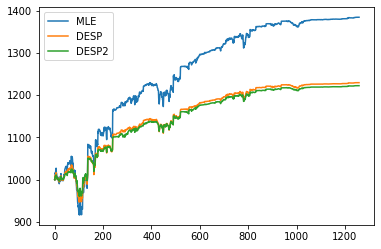

In [ ]:
n0 = St_train.shape[0]-1
obtime = np.arange(0, n0 + 1)/n0 * n0 * 1/252

gamma = -1000

Vt_train = np.zeros(n0+1)
ht_train = np.zeros(n0)
Vt_train_DESP = np.zeros(n0+1)
ht_train_DESP = np.zeros(n0)
Vt_train_DESP2 = np.zeros(n0+1)
ht_train_DESP2 = np.zeros(n0)


v0 = 1000

# MLE
Vt_train[0] = v0
for i in range(n0):
  ht_train[i] = hast(obtime[i], Xt_train[i], MLE_est[0], MLE_est[1], MLE_est[2], MLE_est[3], MLE_est[4], MLE_est[5], obtime[n0],gamma)
  v0 = v0 + v0 *  (ht_train[i] *  (At_train[i+1] - At_train[i])/ At_train[i+1] - ht_train[i] * (Bt_train[i+1] - Bt_train[i]) / Bt_train[i+1])
  Vt_train[i+1] = v0

# DESP
v01 = 1000
Vt_train_DESP[0] = v01
for i in range(n0):
  ht_train_DESP[i] = hast(obtime[i], Xt_train[i], DESP_est[0], DESP_est[1], DESP_est[2], DESP_est[3], DESP_est[4], DESP_est[5], obtime[n0],gamma)
  v01 = v01 + v01 *  (ht_train_DESP[i] *  (At_train[i+1] - At_train[i])/ At_train[i+1] - ht_train_DESP[i] * (Bt_train[i+1] - Bt_train[i]) / Bt_train[i+1])
  Vt_train_DESP[i+1] = v01

v02 = 1000
Vt_train_DESP2[0] = v02
for i in range(n0):
  ht_train_DESP2[i] = hast(obtime[i], Xt_train[i], MLE_est[0], MLE_est[1], DESP_est[2], MLE_est[3], MLE_est[4], MLE_est[5], obtime[n0],gamma)
  v02 = v02 + v02 *  (ht_train_DESP2[i] *  (At_train[i+1] - At_train[i])/ At_train[i+1] - ht_train_DESP2[i] * (Bt_train[i+1] - Bt_train[i]) / Bt_train[i+1])
  Vt_train_DESP2[i+1] = v02


plt.plot(Vt_train)
plt.plot(Vt_train_DESP)
plt.plot(Vt_train_DESP2)
plt.gca().legend(('MLE', 'DESP', 'DESP2'), loc='upper left')

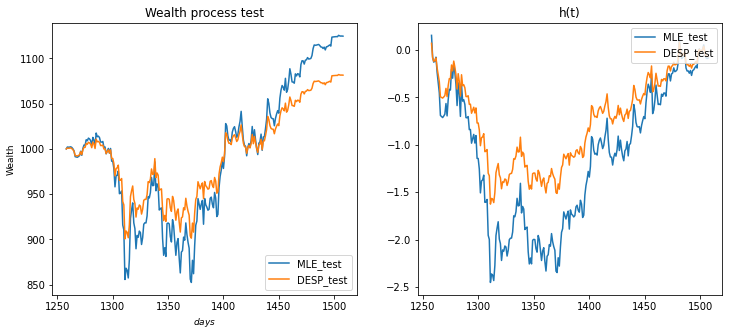

In [ ]:
gamma = -40

Vt_test = np.zeros(n01+1)
ht_test = np.zeros(n01)

Vt_test_DESP = np.zeros(n01+1)
ht_test_DESP = np.zeros(n01)

v011 = 1000
Vt_test[0] = v011
for i in range(n01):
  ht_test[i] = hast(obtime_test[i], Xt_test[i], MLE_est[0], MLE_est[1], MLE_est[2], MLE_est[3], MLE_est[4], MLE_est[5], obtime_test[n01],gamma)
  v011 = v011 + v011 *  (ht_test[i] *  (At_test[i+1] - At_test[i])/ At_test[i+1] - ht_test[i] * (Bt_test[i+1] - Bt_test[i]) / Bt_test[i+1])
  Vt_test[i+1] = v011


v0_test = 1000
Vt_test_DESP[0] = v0_test
for i in range(n01):
  ht_test_DESP[i] = hast(obtime_test[i], Xt_test[i], DESP_est[0], DESP_est[1], DESP_est[2], DESP_est[3], DESP_est[4], DESP_est[5], obtime_test[n01],gamma)
  v0_test = v0_test + v0_test *  (ht_test_DESP[i] *  (At_test[i+1] - At_test[i])/ At_test[i+1] - ht_test_DESP[i] * (Bt_test[i+1] - Bt_test[i]) / Bt_test[i+1])
  Vt_test_DESP[i+1] = v0_test


fig, axes = plt.subplots(1, 2, figsize=(12,5)) 
axes[0].plot(obtime_test*252, Vt_test)
axes[0].plot(obtime_test*252, Vt_test_DESP)
axes[0].title.set_text('Wealth process test')
axes[0].legend(('MLE_test','DESP_test', 'DESP_test2'), loc='lower right')
axes[0].set_xlabel(r'$days$', fontsize=9)
axes[0].set_ylabel(r'Wealth', fontsize=9)

axes[1].plot(obtime_test[range(n01)]*252, ht_test)
axes[1].plot(obtime_test[range(n01)]*252, ht_test_DESP)
axes[1].title.set_text('h(t)')
axes[1].legend(('MLE_test','DESP_test'), loc='upper right')

Text(0, 0.5, 'Wealth')

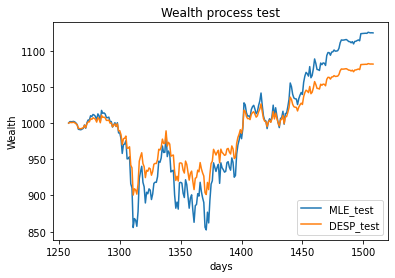

In [ ]:
plt.plot(obtime_test*252, Vt_test)
plt.plot(obtime_test*252, Vt_test_DESP)
plt.title('Wealth process test')
plt.legend(('MLE_test','DESP_test', 'DESP_test2'), loc='lower right')
plt.xlabel(r'days', fontsize=10)
plt.ylabel(r'Wealth', fontsize=10)


In [ ]:
# Generate the simulation data to get the mean and standard deviation of estimated parameter
sim = 5000
torch.manual_seed(4012072726)


obtime = np.arange(0, n0 + n01) * 1/252

param1 = [0.3,0.2, 7.0, 0, 0.2, -0.4]
param2 = [0.2,0.5, 3.0, 0.3, 0.4, 0.5]
param3 = [0.1,0.7, 6.0, 0.1, 0.3, 0.1]


sim_data1 = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*param1[0], torch.ones(sim)*param1[1], torch.ones(sim)*param1[2], torch.ones(sim)*param1[3], torch.ones(sim)*param1[4], torch.ones(sim)*param1[5])
sim_data1_mom = moment_L(sim_data1[:,:,0:(n0+1)]) 
sim_data2 = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*param2[0], torch.ones(sim)*param2[1], torch.ones(sim)*param2[2], torch.ones(sim)*param2[3], torch.ones(sim)*param2[4], torch.ones(sim)*param2[5])
sim_data2_mom = moment_L(sim_data2[:,:,0:(n0+1)])
sim_data3 = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*param3[0], torch.ones(sim)*param3[1], torch.ones(sim)*param3[2], torch.ones(sim)*param3[3], torch.ones(sim)*param3[4], torch.ones(sim)*param3[5])
sim_data3_mom = moment_L(sim_data3[:,:,0:(n0+1)])


In [ ]:
sim = 5000
torch.manual_seed(4012072726)
DESP_est = net(moment_L(lndata_train))[0]
DESP_est = DESP_est.detach().cpu().numpy()
MLE_est = MLE_Multi(lndata_train, 1/252)[0]
MLE_est =MLE_est.detach().cpu().numpy()

param_mle = MLE_est
param_desp = DESP_est

sim_data_mle = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*param_mle[0], torch.ones(sim)*param_mle[1], torch.ones(sim)*param_mle[2], torch.ones(sim)*param_mle[3], torch.ones(sim)*param_mle[4], torch.ones(sim)*param_mle[5])
sim_data_mle_mom = moment_L(sim_data_mle[:,:,0:(n0+1)]) 
sim_data_desp = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*param_desp[0], torch.ones(sim)*param_desp[1], torch.ones(sim)*param_desp[2], torch.ones(sim)*param_desp[3], torch.ones(sim)*param_desp[4], torch.ones(sim)*param_desp[5])
sim_data_desp_mom = moment_L(sim_data_desp[:,:,0:(n0+1)])


In [ ]:
print(torch.mean(net(sim_data1_mom),0),torch.median(net(sim_data1_mom),0),torch.std(net(sim_data1_mom),0)) # (0.3, 0.2, 7.0, 0, 0.2, -0.4)
print(torch.mean(net(sim_data2_mom),0),torch.median(net(sim_data2_mom),0),torch.std(net(sim_data2_mom),0)) # (0, 0.5, 3.0, 0.3, 0.1,0.5)
print(torch.mean(net(sim_data3_mom),0),torch.median(net(sim_data3_mom),0),torch.std(net(sim_data3_mom),0)) # (0.1, 0.7, 6.0, 0.1, 0.3, 0.1)
print(torch.mean(net(sim_data_mle_mom),0),torch.median(net(sim_data_mle_mom),0),torch.std(net(sim_data_mle_mom),0)) # (0.1, 0.7, 6.0, 0.1, 0.3, 0.1)
print(torch.mean(net(sim_data_desp_mom),0),torch.median(net(sim_data_desp_mom),0),torch.std(net(sim_data_desp_mom),0)) # (0.1, 0.7, 6.0, 0.1, 0.3, 0.1)


param_torch1 = torch.stack((torch.ones(sim)*param1[0], torch.ones(sim)*param1[1], torch.ones(sim)*param1[2], torch.ones(sim)*param1[3], torch.ones(sim)*param1[4], torch.ones(sim)*param1[5]),dim=1)
param_torch2 = torch.stack((torch.ones(sim)*param2[0], torch.ones(sim)*param2[1], torch.ones(sim)*param2[2], torch.ones(sim)*param2[3], torch.ones(sim)*param2[4], torch.ones(sim)*param2[5]),dim=1)
param_torch3 = torch.stack((torch.ones(sim)*param3[0], torch.ones(sim)*param3[1], torch.ones(sim)*param3[2], torch.ones(sim)*param3[3], torch.ones(sim)*param3[4], torch.ones(sim)*param3[5]),dim=1)
param_torch_mle = torch.stack((torch.ones(sim)*param_mle[0], torch.ones(sim)*param_mle[1], torch.ones(sim)*param_mle[2], torch.ones(sim)*param_mle[3], torch.ones(sim)*param_mle[4], torch.ones(sim)*param_mle[5]),dim=1)
param_torch_desp = torch.stack((torch.ones(sim)*param_desp[0], torch.ones(sim)*param_desp[1], torch.ones(sim)*param_desp[2], torch.ones(sim)*param_desp[3], torch.ones(sim)*param_desp[4], torch.ones(sim)*param_desp[5]),dim=1)

print(torch.sqrt(torch.sum(torch.square(param_torch1 - net(sim_data1_mom))) /sim))
print(torch.sqrt(torch.sum(torch.square(param_torch2 - net(sim_data2_mom))) /sim))
print(torch.sqrt(torch.sum(torch.square(param_torch3 - net(sim_data3_mom))) /sim))
print(torch.sqrt(torch.sum(torch.square(param_torch_mle - net(sim_data_mle_mom))) /sim))
print(torch.sqrt(torch.sum(torch.square(param_torch_desp - net(sim_data_desp_mom))) /sim))


tensor([ 2.9270e-01,  1.6037e-01,  6.5541e+00,  1.5225e-03,  1.9657e-01,
        -4.9018e-01], grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([ 2.9196e-01,  1.6078e-01,  6.6074e+00,  9.8199e-06,  1.9700e-01,
        -4.9249e-01], grad_fn=<MedianBackward1>),
indices=tensor([1005,  760,  440, 4051, 1339, 2807])) tensor([0.0973, 0.0089, 0.9386, 0.0156, 0.0091, 0.0276],
       grad_fn=<StdBackward0>)
tensor([0.2169, 0.4561, 3.4629, 0.2858, 0.3991, 0.5599],
       grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([0.2240, 0.4557, 3.1921, 0.2763, 0.3988, 0.5616],
       grad_fn=<MedianBackward1>),
indices=tensor([4164, 4407, 4972, 4402, 1325,  766])) tensor([0.2044, 0.0199, 0.9047, 0.0587, 0.0126, 0.0391],
       grad_fn=<StdBackward0>)
tensor([0.1085, 0.6818, 6.0994, 0.0776, 0.3006, 0.1575],
       grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([0.1062, 0.6820, 6.2288, 0.0776, 0.3007, 0.1586],
       grad_fn=<MedianBackward1>),
indices=t

In [ ]:
results1 = MLE_Multi(sim_data1, 1/252)
results2 = MLE_Multi(sim_data2, 1/252)
results3 = MLE_Multi(sim_data3, 1/252)
results_mle = MLE_Multi(sim_data_mle, 1/252)
results_desp = MLE_Multi(sim_data_desp, 1/252)

print(torch.sqrt(torch.sum(torch.square(param_torch1 - results1)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch2 - results2)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch3 - results3)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch_mle - results_mle)) /sim) )
print(torch.sqrt(torch.sum(torch.square(param_torch_desp - results_desp)) /sim) )

print(torch.mean(results1,0), torch.std(results1,0))
print(torch.mean(results2,0), torch.std(results2,0))
print(torch.mean(results3,0), torch.std(results3,0))
print(torch.mean(results_mle,0), torch.std(results_mle,0))
print(torch.mean(results_desp,0), torch.std(results_desp,0))


tensor(1.8804)
tensor(1.3719)
tensor(1.7599)
tensor(1.9286)
tensor(1.7116)
tensor([ 3.0177e-01,  1.9991e-01,  7.7306e+00, -7.3748e-05,  2.0027e-01,
        -3.9981e-01]) tensor([0.0831, 0.0036, 1.7307, 0.0116, 0.0036, 0.0214])
tensor([0.1996, 0.4997, 3.6523, 0.2983, 0.4001, 0.4997]) tensor([0.2063, 0.0090, 1.1878, 0.0552, 0.0072, 0.0194])
tensor([0.0969, 0.6996, 6.7233, 0.1001, 0.3004, 0.0996]) tensor([0.2862, 0.0130, 1.5784, 0.0205, 0.0056, 0.0256])
tensor([ 2.7943e-01,  2.2330e-01,  8.2115e+00,  5.0855e-04,  2.4995e-01,
        -4.7817e-01]) tensor([0.0925, 0.0040, 1.7819, 0.0136, 0.0046, 0.0197])
tensor([ 2.5567e-01,  1.8393e-01,  6.2605e+00, -9.7914e-04,  2.4557e-01,
        -5.2631e-01]) tensor([0.0757, 0.0033, 1.5442, 0.0180, 0.0046, 0.0187])


In [ ]:
def hast_torch(time, X, mu, sigma, kappa, alpha, eta, rho, timeT, gamma):
  # X, mu, sigma, kappa, alpha, eta, rho : torch
  # time, timeT, gamma : constant
  L0 = mu.size()[0]
  tmp = np.sqrt(1-gamma)
  tmp2 = torch.exp(2*kappa* (timeT- time) / tmp)
  alphat = kappa * (torch.ones(L0) - tmp)/ (2* eta**2) * (torch.ones(L0) + 2 * tmp / (torch.ones(L0) - tmp - (torch.ones(L0)+ tmp) *tmp2 ) )
  betat = 1/ (2*eta**2 * ( (torch.ones(L0)-tmp) - (torch.ones(L0)+tmp) *tmp2) ) 
  betat = betat * (gamma*tmp*(eta**2+2*rho*sigma*eta) * (torch.ones(L0)-tmp2)**2 - gamma* (eta**2 + 2*rho*sigma*eta+2*kappa*alpha)* (torch.ones(L0)-tmp2) )
  result = 1/ (torch.ones(L0)-gamma) * (betat+ 2* X * alphat - kappa* (X-alpha)/eta**2 + rho* sigma/eta + 1/2*torch.ones(L0))
  return(result)

In [ ]:
sim=5000
###########################################
### You can change simulation data here ###
sim_data = sim_data3                    ###
param = param3                          ###
###########################################

gamma_array = np.arange(-150, -20, 5)
gamma_num = len(gamma_array)
res_mean = np.zeros((gamma_num,6))
res_median = np.zeros((gamma_num,6))
res_std = np.zeros((gamma_num,6))
res_1q = np.zeros((gamma_num,6))
res_3q = np.zeros((gamma_num,6))


for j in range(gamma_num):
  gamma = gamma_array[j]  
  Vt_tr   = torch.zeros(sim, n01+1)
  Vt_desp = torch.zeros(sim, n01+1)
  Vt_mle  = torch.zeros(sim, n01+1)

  ht_tr   = torch.zeros(sim, n01) 
  ht_desp = torch.zeros(sim, n01)
  ht_mle  = torch.zeros(sim, n01)

  # Initial value
  v0_tr   = 1000 * torch.ones(sim)
  v0_desp = 1000 * torch.ones(sim)
  v0_mle  = 1000 * torch.ones(sim)

  St = sim_data[:,0, (n0-1):(n0 + n01)]
  Xt = sim_data[:,1, (n0-1):(n0 + n01)]
  lnAt = Xt + St
  At = torch.exp(lnAt)
  Bt = torch.exp(St)

  # Estimation
  DESP_est = net(moment_L(sim_data[:,:,0:(n0+1)]))
  MLE_est = MLE_Multi(sim_data[:,:,0:(n0+1)], 1/252)

  # Put initial value
  Vt_tr[:,0] = v0_tr
  Vt_desp[:,0] = v0_desp
  Vt_mle[:,0] = v0_mle


  for i in range(n01):
    # True value
    ht_tr[:,i] = hast_torch(obtime_test[i], Xt[:,i], param[0]*torch.ones(sim), param[1]*torch.ones(sim), param[2]*torch.ones(sim), param[3]*torch.ones(sim), param[4]*torch.ones(sim), param[5]*torch.ones(sim), obtime_test[n01],gamma)
    v0_tr = v0_tr + v0_tr *  (ht_tr[:,i] *  (At[:,i+1] - At[:,i])/ At[:,i+1] - ht_tr[:,i] * (Bt[:,i+1] - Bt[:,i]) / Bt[:,i+1]) 
    Vt_tr[:,i+1] = v0_tr

    # DESP-NN
    ht_desp[:,i] = hast_torch(obtime_test[i], Xt[:,i], DESP_est[:,0], DESP_est[:,1], DESP_est[:,2], DESP_est[:,3], DESP_est[:,4], DESP_est[:,5], obtime_test[n01],gamma)
    v0_desp = v0_desp + v0_desp *  (ht_desp[:,i] *  (At[:,i+1] - At[:,i])/ At[:,i+1] - ht_desp[:,i] * (Bt[:,i+1] - Bt[:,i]) / Bt[:,i+1]) 
    Vt_desp[:,i+1] = v0_desp

    # MLE
    ht_mle[:,i] = hast_torch(obtime_test[i], Xt[:,i], MLE_est[:,0], MLE_est[:,1], MLE_est[:,2], MLE_est[:,3], MLE_est[:,4], MLE_est[:,5], obtime_test[n01],gamma)
    v0_mle = v0_mle + v0_mle *  (ht_mle[:,i] *  (At[:,i+1] - At[:,i])/ At[:,i+1] - ht_mle[:,i] * (Bt[:,i+1] - Bt[:,i]) / Bt[:,i+1]) 
    Vt_mle[:,i+1] = v0_mle

  diff2_desp  = (torch.sqrt(torch.sum(torch.square(Vt_tr - Vt_desp),1)/sim)/1000).detach().cpu().numpy().tolist()
  diff2_mle = (torch.sqrt(torch.sum(torch.square(Vt_tr - Vt_mle),1)/sim)/1000).detach().cpu().numpy().tolist()

  diff1_desp = ((torch.sum(torch.abs(Vt_tr - Vt_desp),1)/sim)/1000).detach().cpu().numpy().tolist()
  diff1_mle = (torch.sum(torch.abs(Vt_tr - Vt_mle),1)/sim/1000).detach().cpu().numpy().tolist()

  W_desp = (torch.abs(Vt_tr[:,n01] - Vt_desp[:,n01])/1000).detach().cpu().numpy().tolist()
  W_mle = (torch.abs(Vt_tr[:,n01] - Vt_mle[:,n01])/1000).detach().cpu().numpy().tolist()


  res_mean[j,:] = np.array([np.mean(diff2_desp), np.mean(diff2_mle), np.mean(diff1_desp), np.mean(diff1_mle), np.mean(W_desp), np.mean(W_mle)])
  res_median[j,:] = np.array([np.median(diff2_desp), np.median(diff2_mle), np.median(diff1_desp), np.median(diff1_mle), np.median(W_desp), np.median(W_mle)])
  res_std[j,:] = np.array([np.std(diff2_desp), np.std(diff2_mle), np.std(diff1_desp), np.std(diff1_mle), np.std(W_desp), np.std(W_mle)])
  res_1q[j,:] = np.array([np.quantile(diff2_desp, 1/10), np.quantile(diff2_mle, 0.5/10), np.quantile(diff1_desp, 0.5/10), np.quantile(diff1_mle,0.5/10), np.quantile(W_desp, 0.5/10), np.quantile(W_mle,0.5/10)]) # first 10%
  res_3q[j,:] = np.array([np.quantile(diff2_desp, 9/10), np.quantile(diff2_mle, 9.5/10), np.quantile(diff1_desp, 9.5/10), np.quantile(diff1_mle,9.5/10), np.quantile(W_desp, 9.5/10), np.quantile(W_mle,9.5/10)]) # first 90%

Text(0, 0.5, 'D2')

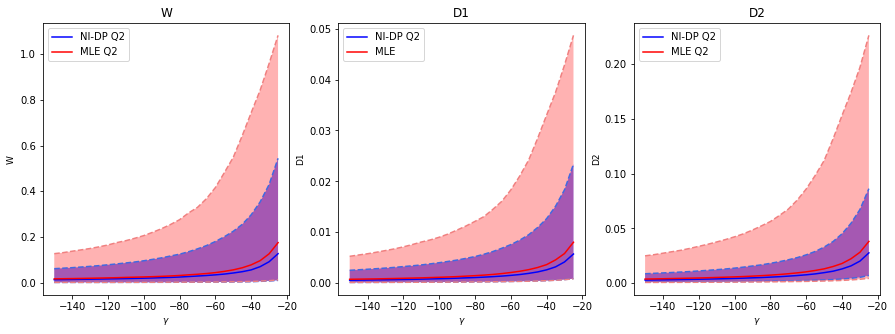

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(gamma_array, res_median[:,4],color = "blue", label = "NI-DP Q2")
axs[0].plot(gamma_array, res_1q[:,4],color = "royalblue", linestyle = "--")
axs[0].plot(gamma_array, res_3q[:,4],color = "royalblue", linestyle = "--")
axs[0].fill_between(gamma_array,res_1q[:,4], res_3q[:,4], facecolor='blue', alpha=0.5)
axs[0].plot(gamma_array, res_median[:,5],color = "red", label = "MLE Q2")
axs[0].plot(gamma_array, res_1q[:,5],color = "lightcoral", linestyle = "--")
axs[0].plot(gamma_array, res_3q[:,5],color = "lightcoral", linestyle = "--")
axs[0].fill_between(gamma_array,res_1q[:,5], res_3q[:,5], facecolor='red', alpha=0.3)
axs[0].legend(loc='upper left')
axs[0].title.set_text('W')
axs[0].set_xlabel(r'$\gamma$', fontsize=9)
axs[0].set_ylabel(r'W', fontsize=9)

axs[1].plot(gamma_array, res_median[:,2],color = "blue", label = "NI-DP Q2")
axs[1].plot(gamma_array, res_1q[:,2],color = "royalblue", linestyle = "--")
axs[1].plot(gamma_array, res_3q[:,2],color = "royalblue", linestyle = "--")
axs[1].fill_between(gamma_array,res_1q[:,2], res_3q[:,2], facecolor='blue', alpha=0.5)
#axs[1].plot(gamma_array, res_mean[:,2],color = "navy", label = "DESP mean")

axs[1].plot(gamma_array, res_median[:,3],color = "red", label = "MLE")
axs[1].plot(gamma_array, res_1q[:,3],color = "lightcoral", linestyle = "--")
axs[1].plot(gamma_array, res_3q[:,3],color = "lightcoral", linestyle = "--")
axs[1].fill_between(gamma_array,res_1q[:,3], res_3q[:,3], facecolor='red', alpha=0.3)
#axs[1].plot(gamma_array, res_mean[:,3],color = "darkorange", label = "MLE mean")

axs[1].legend(loc='upper left')
axs[1].title.set_text('D1')
axs[1].set_xlabel(r'$\gamma$', fontsize=9)
axs[1].set_ylabel(r'D1', fontsize=9)

axs[2].plot(gamma_array, res_median[:,0],color = "blue", label = "NI-DP Q2")
axs[2].plot(gamma_array, res_1q[:,0],color = "royalblue", linestyle = "--")
axs[2].plot(gamma_array, res_3q[:,0],color = "royalblue", linestyle = "--")
axs[2].fill_between(gamma_array,res_1q[:,0], res_3q[:,0], facecolor='blue', alpha=0.5)
axs[2].plot(gamma_array, res_median[:,1],color = "red", label = "MLE Q2")
axs[2].plot(gamma_array, res_1q[:,1],color = "lightcoral", linestyle = "--")
axs[2].plot(gamma_array, res_3q[:,1],color = "lightcoral", linestyle = "--")
axs[2].fill_between(gamma_array,res_1q[:,1], res_3q[:,1], facecolor='red', alpha=0.3)
axs[2].legend(loc='upper left')
axs[2].title.set_text('D2')
axs[2].set_xlabel(r'$\gamma$', fontsize=9)
axs[2].set_ylabel(r'D2', fontsize=9)

#fig.savefig("Wealthdist_nidp.pdf", bbox_inches='tight')
#files.download("Wealthdist_nidp.pdf")


[ 2.7801135e-01  2.2339819e-01  7.4795947e+00  6.0724549e-04
  2.4960239e-01 -4.7840086e-01]
[ 2.5558600e-01  1.8403468e-01  5.5261779e+00 -8.7808073e-04
  2.4535632e-01 -5.2643275e-01]


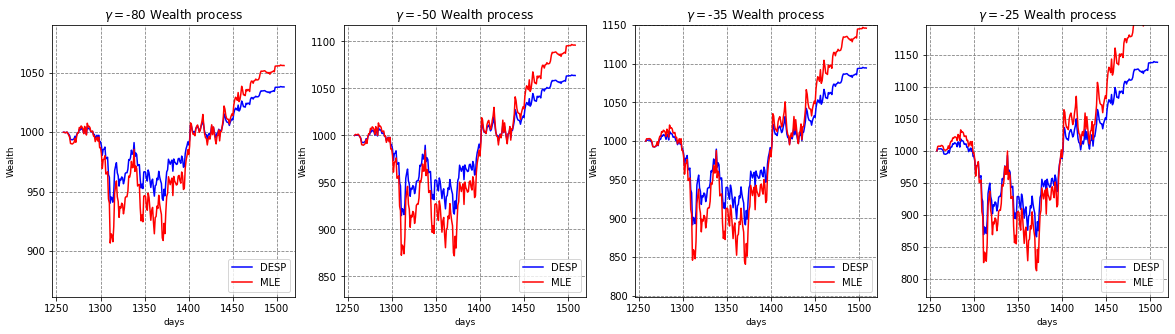

In [ ]:
DESP_est = net(moment_L(lndata_train))[0]
DESP_est = DESP_est.detach().cpu().numpy()
MLE_est = MLE_Multi(lndata_train, 1/252)[0]
MLE_est =MLE_est.detach().cpu().numpy()
print(MLE_est)
print(DESP_est)

torch.manual_seed(4012072726)
gamma_array = np.array([-80, -50, -35, -25])

Vt_gam_mle = np.zeros((len(gamma_array),n01+1))
Vt_gam_desp = np.zeros((len(gamma_array),n01+1))
#Vt_gam_desp2 = np.zeros((len(gamma_array),n01+1))

for j in range(len(gamma_array)):
  gamma = gamma_array[j]

  Vt_test = np.zeros(n01+1)
  ht_test = np.zeros(n01)

  Vt_test_DESP = np.zeros(n01+1)
  ht_test_DESP = np.zeros(n01)

  #Vt_test_DESP2 = np.zeros(n01+1)
  #ht_test_DESP2 = np.zeros(n01)

  v011 = 1000
  Vt_test[0] = v011
  for i in range(n01):
    ht_test[i] = hast(obtime_test[i], Xt_test[i], MLE_est[0], MLE_est[1], MLE_est[2], MLE_est[3], MLE_est[4], MLE_est[5], obtime_test[n01],gamma)
    v011 = v011 + v011 *  (ht_test[i] *  (At_test[i+1] - At_test[i])/ At_test[i+1] - ht_test[i] * (Bt_test[i+1] - Bt_test[i]) / Bt_test[i+1])
    Vt_test[i+1] = v011


  v0_test = 1000
  Vt_test_DESP[0] = v0_test
  for i in range(n01):
    ht_test_DESP[i] = hast(obtime_test[i], Xt_test[i], DESP_est[0], DESP_est[1], DESP_est[2], DESP_est[3], DESP_est[4], DESP_est[5], obtime_test[n01],gamma)
    v0_test = v0_test + v0_test *  (ht_test_DESP[i] *  (At_test[i+1] - At_test[i])/ At_test[i+1] - ht_test_DESP[i] * (Bt_test[i+1] - Bt_test[i]) / Bt_test[i+1])
    Vt_test_DESP[i+1] = v0_test

  #v0_test2 = 1000
  #Vt_test_DESP2[0] = v0_test2
  #for i in range(n01):
    #ht_test_DESP2[i] = hast(obtime_test[i], Xt_test[i], MLE_est[0], MLE_est[1], DESP_est[2], MLE_est[3], MLE_est[4], MLE_est[5], obtime_test[n01],gamma)
    #v0_test2 = v0_test2 + v0_test2 *  (ht_test_DESP2[i] *  (At_test[i+1] - At_test[i])/ At_test[i+1] - ht_test_DESP2[i] * (Bt_test[i+1] - Bt_test[i]) / Bt_test[i+1])
    #Vt_test_DESP2[i+1] = v0_test2

  Vt_gam_mle[j,:] = Vt_test
  Vt_gam_desp[j,:] = Vt_test_DESP
  #Vt_gam_desp2[j,:] = Vt_test_DESP2

fig, axes = plt.subplots(1, len(gamma_array), figsize=(5*len(gamma_array),5)) 
for j in range(len(gamma_array)):
  axes[j].plot(obtime_test*252, Vt_gam_desp[j,:], color = "blue")
  axes[j].plot(obtime_test*252, Vt_gam_mle[j,:], color = "red")
  #axes[j].plot(obtime_test*252, Vt_gam_desp2[j,:], color = "green")
  
  axes[j].set_ylim([np.min(Vt_gam_mle[j,:])*0.95, np.max(Vt_gam_desp[j,:])*1.05 ] )
  axes[j].title.set_text(r'$\gamma=$'+str(gamma_array[j])+' Wealth process')
  axes[j].legend(('DESP','MLE'), loc='lower right')
  axes[j].set_xlabel(r'days', fontsize=9)
  axes[j].set_ylabel(r'Wealth', fontsize=9)
  axes[j].set_axisbelow(True)
  axes[j].grid(color='gray', linestyle='dashed')

#fig.savefig("backtest.pdf", bbox_inches='tight')
#files.download("backtest.pdf")


In [ ]:
# If MLE is true

DESP_est = net(moment_L(lndata_train))[0]
DESP_est = DESP_est.detach().cpu().numpy()
MLE_est = MLE_Multi(lndata_train, 1/252)[0]
MLE_est =MLE_est.detach().cpu().numpy()
print(MLE_est)
print(DESP_est)
MLE_est[0]

[ 2.7801135e-01  2.2339819e-01  7.4795947e+00  6.0724549e-04
  2.4960239e-01 -4.7840086e-01]
[ 2.5558600e-01  1.8403468e-01  5.5261779e+00 -8.7808073e-04
  2.4535632e-01 -5.2643275e-01]


0.27801135

In [ ]:
torch.manual_seed(510)
sim = 5000
sim_data_MLE = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*MLE_est[0],torch.ones(sim)*MLE_est[1],torch.ones(sim)*MLE_est[2],torch.ones(sim)*MLE_est[3],torch.ones(sim)*MLE_est[4], torch.ones(sim)*MLE_est[5])
sim_data_DESP = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*DESP_est[0],torch.ones(sim)*DESP_est[1],torch.ones(sim)*DESP_est[2],torch.ones(sim)*DESP_est[3],torch.ones(sim)*DESP_est[4], torch.ones(sim)*DESP_est[5])
#sim_data_DESP2 = Multi_sample(torch.ones(sim) * s0, torch.ones(sim) *x0, obtime, 20, torch.ones(sim)*MLE_est[0],torch.ones(sim)*MLE_est[1],torch.ones(sim)*DESP_est[2],torch.ones(sim)*MLE_est[3],torch.ones(sim)*MLE_est[4], torch.ones(sim)*MLE_est[5])

Vt_gam_mle_q1 = np.zeros((len(gamma_array),n01+1))
Vt_gam_mle_q1_5 = np.zeros((len(gamma_array),n01+1))
Vt_gam_desp_q1 = np.zeros((len(gamma_array),n01+1))
Vt_gam_desp_q1_5 = np.zeros((len(gamma_array),n01+1))

Vt_gam_mle_q9 = np.zeros((len(gamma_array),n01+1))
Vt_gam_mle_q9_5 = np.zeros((len(gamma_array),n01+1))
Vt_gam_desp_q9 = np.zeros((len(gamma_array),n01+1))
Vt_gam_desp_q9_5 = np.zeros((len(gamma_array),n01+1))

for j in range(len(gamma_array)):
  gamma = gamma_array[j]

  Vt_mle  = torch.zeros(sim, n01+1)
  Vt_desp   = torch.zeros(sim, n01+1)
  #Vt_desp2   = torch.zeros(sim, n01+1)

  ht_mle  = torch.zeros(sim, n01)
  ht_desp = torch.zeros(sim, n01)
  #ht_desp2 = torch.zeros(sim, n01)
  
  # Initial value
  v0_mle  = 1000 * torch.ones(sim)
  v0_desp   = 1000 * torch.ones(sim)
  #v0_desp2   = 1000 * torch.ones(sim)

  St_mle = sim_data_MLE[:,0, (n0-1):(n0 + n01)]
  Xt_mle = sim_data_MLE[:,1, (n0-1):(n0 + n01)]
  lnAt_mle = Xt_mle + St_mle
  At_mle = torch.exp(lnAt_mle)
  Bt_mle = torch.exp(St_mle)

  St_desp = sim_data_DESP[:,0, (n0-1):(n0 + n01)]
  Xt_desp = sim_data_DESP[:,1, (n0-1):(n0 + n01)]
  lnAt_desp = Xt_desp + St_desp
  At_desp = torch.exp(lnAt_desp)
  Bt_desp = torch.exp(St_desp)

  #St_desp2 = sim_data_DESP2[:,0, (n0-1):(n0 + n01)]
  #Xt_desp2 = sim_data_DESP2[:,1, (n0-1):(n0 + n01)]
  #lnAt_desp2 = Xt_desp2 + St_desp2
  #At_desp2 = torch.exp(lnAt_desp2)
  #Bt_desp2 = torch.exp(St_desp2)

  # Put initial value
  Vt_mle[:,0] = v0_mle
  Vt_desp[:,0] = v0_desp
  #Vt_desp2[:,0] = v0_desp2
  
  for i in range(n01):
    # MLE
    ht_mle[:,i] = hast_torch(obtime_test[i], Xt_mle[:,i], torch.ones(sim)*MLE_est[0], torch.ones(sim)*MLE_est[1], torch.ones(sim)*MLE_est[2], torch.ones(sim)*MLE_est[3], torch.ones(sim)*MLE_est[4], torch.ones(sim)*MLE_est[5], obtime_test[n01], gamma)
    v0_mle = v0_mle + v0_mle *  (ht_mle[:,i] *  (At_mle[:,i+1] - At_mle[:,i])/ At_mle[:,i+1] - ht_mle[:,i] * (Bt_mle[:,i+1] - Bt_mle[:,i]) / Bt_mle[:,i+1]) 
    Vt_mle[:,i+1] = v0_mle

    # DESP
    ht_desp[:,i] = hast_torch(obtime_test[i], Xt_desp[:,i], torch.ones(sim)*DESP_est[0], torch.ones(sim)*DESP_est[1], torch.ones(sim)*DESP_est[2], torch.ones(sim)*DESP_est[3], torch.ones(sim)*DESP_est[4], torch.ones(sim)*DESP_est[5], obtime_test[n01], gamma)
    v0_desp = v0_desp + v0_desp *  (ht_desp[:,i] *  (At_desp[:,i+1] - At_desp[:,i])/ At_desp[:,i+1] - ht_desp[:,i] * (Bt_desp[:,i+1] - Bt_desp[:,i]) / Bt_desp[:,i+1]) 
    Vt_desp[:,i+1] = v0_desp

    # DESP
    #ht_desp2[:,i] = hast_torch(obtime_test[i], Xt_desp[:,i], torch.ones(sim)*MLE_est[0], torch.ones(sim)*MLE_est[1], torch.ones(sim)*DESP_est[2], torch.ones(sim)*MLE_est[3], torch.ones(sim)*MLE_est[4], torch.ones(sim)*MLE_est[5], obtime_test[n01], gamma)
    #v0_desp2 = v0_desp2 + v0_desp2 *  (ht_desp2[:,i] *  (At_desp2[:,i+1] - At_desp2[:,i])/ At_desp2[:,i+1] - ht_desp2[:,i] * (Bt_desp2[:,i+1] - Bt_desp2[:,i]) / Bt_desp2[:,i+1]) 
    #Vt_desp2[:,i+1] = v0_desp2

  Vt_gam_mle_q1[j,:] = torch.quantile(Vt_mle, q = 0.005, dim=0).detach().cpu().numpy()
  Vt_gam_mle_q9[j,:] = torch.quantile(Vt_mle, q = 0.995, dim=0).detach().cpu().numpy()  
  
  Vt_gam_mle_q1_5[j,:] = torch.quantile(Vt_mle, q = 0.0025, dim=0).detach().cpu().numpy()
  Vt_gam_mle_q9_5[j,:] = torch.quantile(Vt_mle, q = 0.9975, dim=0).detach().cpu().numpy()  
  
  Vt_gam_desp_q1[j,:] = torch.quantile(Vt_desp, q = 0.005, dim=0).detach().cpu().numpy()
  Vt_gam_desp_q9[j,:] = torch.quantile(Vt_desp, q = 0.995, dim=0).detach().cpu().numpy()
  
  
  Vt_gam_desp_q1_5[j,:] = torch.quantile(Vt_desp, q = 0.0025, dim=0).detach().cpu().numpy()
  Vt_gam_desp_q9_5[j,:] = torch.quantile(Vt_desp, q = 0.9975, dim=0).detach().cpu().numpy()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

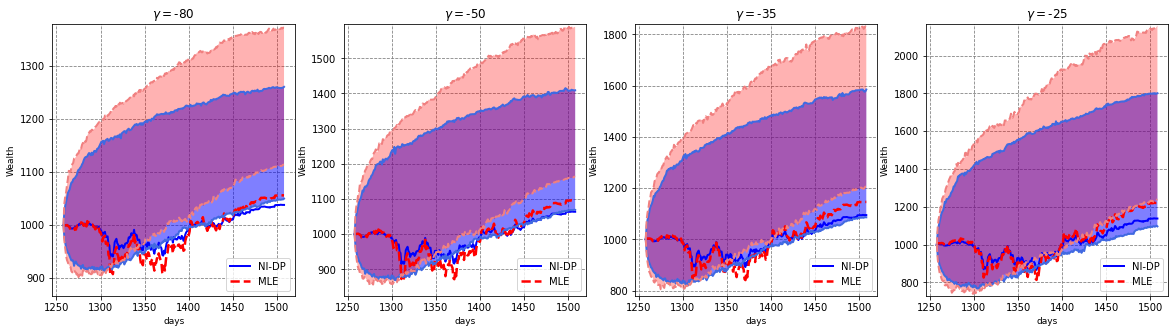

In [ ]:
fig, axes = plt.subplots(1, len(gamma_array), figsize=(5*len(gamma_array),5)) 
for j in range(len(gamma_array)):
  axes[j].plot(obtime_test*252, Vt_gam_desp[j,:], color = "blue", linewidth=2.0)
  axes[j].plot(obtime_test*252, Vt_gam_mle[j,:], color = "red", linestyle='dashed', linewidth=2.5)
  #axes[j].plot(obtime_test*252, Vt_gam_desp2[j,:], color = "green")
  
  axes[j].plot(obtime_test*252, Vt_gam_desp_q1[j,:], color = "royalblue", linewidth=2.0)
  axes[j].plot(obtime_test*252, Vt_gam_desp_q9[j,:], color = "royalblue", linewidth=2.0)
  axes[j].fill_between(obtime_test*252,Vt_gam_desp_q1[j,:], Vt_gam_desp_q9[j,:], facecolor='blue', alpha=0.5)
  axes[j].plot(obtime_test*252, Vt_gam_mle_q1[j,:], color = "lightcoral", linestyle='dashed', linewidth=2.0)
  axes[j].plot(obtime_test*252, Vt_gam_mle_q9[j,:], color = "lightcoral", linestyle='dashed', linewidth=2.0)
  axes[j].fill_between(obtime_test*252,Vt_gam_mle_q1[j,:], Vt_gam_mle_q9[j,:], facecolor='red', alpha=0.3)

  axes[j].set_ylim([np.min(Vt_gam_desp_q1[j,:])*0.95, np.max(Vt_gam_mle_q9[j,:])*1.005 ] )
  axes[j].title.set_text(r'$\gamma=$'+str(gamma_array[j]))
  axes[j].legend(('NCoin-DP','MLE'), loc='lower right')
  axes[j].set_xlabel(r'days', fontsize=9)
  axes[j].set_ylabel(r'Wealth', fontsize=9)
  axes[j].set_axisbelow(True)
  axes[j].grid(color='gray', linestyle='dashed')

fig.savefig("backtest.pdf", bbox_inches='tight')
files.download("backtest.pdf")


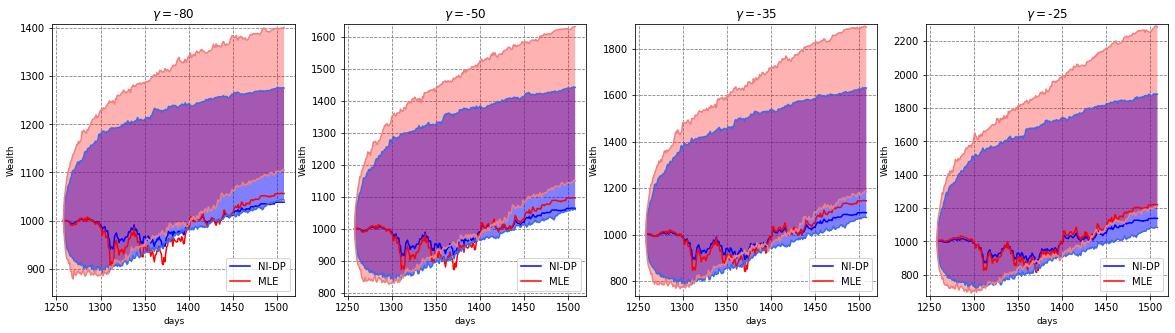

In [ ]:
fig, axes = plt.subplots(1, len(gamma_array), figsize=(5*len(gamma_array),5)) 
for j in range(len(gamma_array)):
  axes[j].plot(obtime_test*252, Vt_gam_desp[j,:], color = "blue")
  axes[j].plot(obtime_test*252, Vt_gam_mle[j,:], color = "red", linestyle='dashed')
  #axes[j].plot(obtime_test*252, Vt_gam_desp2[j,:], color = "green")
  
  axes[j].plot(obtime_test*252, Vt_gam_desp_q1_5[j,:], color = "royalblue")
  axes[j].plot(obtime_test*252, Vt_gam_desp_q9_5[j,:], color = "royalblue")
  axes[j].fill_between(obtime_test*252,Vt_gam_desp_q1_5[j,:], Vt_gam_desp_q9_5[j,:], facecolor='blue', alpha=0.5)
  axes[j].plot(obtime_test*252, Vt_gam_mle_q1_5[j,:], color = "lightcoral", linestyle='dashed')
  axes[j].plot(obtime_test*252, Vt_gam_mle_q9_5[j,:], color = "lightcoral", linestyle='dashed')
  axes[j].fill_between(obtime_test*252,Vt_gam_mle_q1_5[j,:], Vt_gam_mle_q9_5[j,:], facecolor='red', alpha=0.3)

  #axes[j].plot(obtime_test*252, Vt_gam_desp2_q1[j,:], color = "lightgreen")
  #axes[j].plot(obtime_test*252, Vt_gam_desp2_q9[j,:], color = "lightgreen")
  #axes[j].fill_between(obtime_test*252,Vt_gam_desp2_q1[j,:], Vt_gam_desp2_q9[j,:], facecolor='green', alpha=0.5)

  axes[j].set_ylim([np.min(Vt_gam_desp_q1_5[j,:])*0.95, np.max(Vt_gam_mle_q9_5[j,:])*1.005 ] )
  axes[j].title.set_text(r'$\gamma=$'+str(gamma_array[j]))
  axes[j].legend(('NI-DP','MLE'), loc='lower right')
  #axes[j].legend(('DESP','MLE','DESP2'), loc='lower right')
  axes[j].set_xlabel(r'days', fontsize=9)
  axes[j].set_ylabel(r'Wealth', fontsize=9)
  axes[j].set_axisbelow(True)
  axes[j].grid(color='gray', linestyle='dashed')

#fig.savefig("backtest2.pdf", bbox_inches='tight')
#files.download("backtest2.pdf")
